<a href="https://colab.research.google.com/github/vibeeshK/Twitter-US-Airline-Sentiment-using-ULMFiT-model/blob/master/Twitter%20US%20Airline%20Sentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import Packages**

In [1]:
import pandas as pd
import numpy as np
from fastai.text import *
from pathlib import Path            
import io
from google.colab import files
uploaded = files.upload()

Saving Tweets.csv to Tweets.csv


In [4]:
import numpy as np
from fastai.text import *
from pathlib import Path
path=Path.cwd()
path=path

**Get the data**

In [2]:
df_org = pd.read_csv(io.BytesIO(uploaded['Tweets.csv']))
df_org.rename(columns={'airline_sentiment':'label'},inplace=True)               
df=df_org[['label','text']]
np.random.seed(2020)
df['is_valid']=np.random.choice([True, False], len(df_org), p=[0.9,0.1 ]) # Seperate 10% for test
df.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,label,text,is_valid
0,neutral,@VirginAmerica What @dhepburn said.,False
1,positive,@VirginAmerica plus you've added commercials t...,True
2,neutral,@VirginAmerica I didn't today... Must mean I n...,True
3,negative,@VirginAmerica it's really aggressive to blast...,True
4,negative,@VirginAmerica and it's a really big bad thing...,True


**Data Visualiation**

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


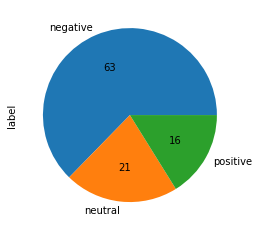

In [40]:
#To have an idea about the distribution of the sentiment labels we will present the frequency distribution over the pie chart and histograms.
import seaborn as sns
df.label.value_counts().plot(kind='pie',autopct='%1.0f')

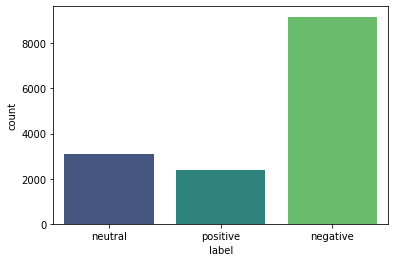

In [41]:
# Sentiment distribution
sns.countplot(x='label',data=df,palette='viridis')

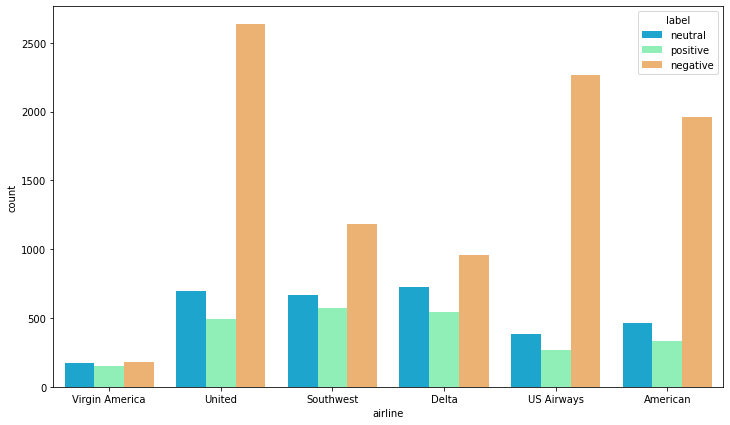

In [42]:
#sentiment distribution over airelines 
plt.figure(figsize=(12,7))
sns.countplot(x='airline',hue='label',data=df_org,palette='rainbow')

In [6]:
df[['label','text','is_valid']].to_csv(path/'Tweets.csv',index=False)


**Data preprocessing**

Creating Data Bunches

In [7]:
bs=48
data_lm = (TextList.from_csv(path, 'Tweets.csv', cols='text') 
            .split_by_rand_pct(0.1,seed=2020)
           #We randomly split and keep 10% (10,000 reviews) for validation
            .label_for_lm()           
           #We want to do a language model so we label accordingly
            .databunch(bs=bs))


Save DataBunch object

In [8]:
data_lm.save('data_lm.pkl')
data_lm = load_data(path, 'data_lm.pkl', bs=bs)
# Lets have a look at the first item of the training set
data_lm.train_ds[0][0]

Text [  2 104   5  71   0 254   9]

Looking at the first item of the training set, we see that underlying data is all numbers

In [9]:
data_lm.train_ds[0][0].data[:10]


array([  2, 104,   5,  71,   0, 254,   9])

To see what the tokenizer had done behind the scenes, let's have a look at a few texts in a batch.

In [10]:
data_lm.show_batch()


/usr/local/lib/python3.6/dist-packages/fastai/text/data.py:339: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  idx_min = (t != self.pad_idx).nonzero().min()


idx,text
0,"about it xxbos @virginamerica seriously would pay $ 30 a flight for seats that did n't have this playing . \n it 's really the only bad thing about flying xxup va xxbos @virginamerica yes , nearly every time i fly xxup vx this “ xxunk xxunk ” wo n’t go away :) xxbos @virginamerica xxmaj really missed a prime opportunity for xxmaj men xxmaj without xxmaj hats xxunk"
1,". xxmaj do n't worry , i 'll keep trying :) xxbos @virginamerica xxmaj many xxmaj thanks for the xxmaj follow . \n # xxunk # xxunk # xxup usa # xxmaj xxunk \n xxmaj looking for xxmaj any xxmaj help 😍 \n 💗 🇬 🇧 💗 🇺 🇸 💗 \n 🎀 xxunk 🎀 http : / / t.co / xxunk xxbos @virginamerica xxmaj nice ,"
2,to be held xxunk for their error xxbos @united a xxmaj tourist xxmaj wonder : xxmaj super xxmaj xxunk and xxmaj xxunk of the xxmaj century at xxmaj french and xxup xxunk xxunk : http : / / t.co / xxunk xxbos @united xxmaj yeah sorry but there 's always a problem with xxmaj united . xxmaj and you have an international reputation for having problems . xxbos @united y
3,"that is not in line with your responses here . xxmaj and now i 'm waiting until tomorrow morning because all the flights are overbooked . xxbos @united i took the exact same aircraft in to xxup lax 3 days ago . xxmaj it fit , no problem . xxmaj the agent today told some nonsense about a policy change xxbos @united your helpful agents in xxmaj club helped ."
4,to start daily # xxup xxunk - xxup xxunk flights from # xxmaj newark to # xxmaj milan # xxmaj xxunk replacing # xxup b767 - xxup 400er on xxup xxunk instead xxup xxunk # avgeek xxbos @united to start daily # xxup xxunk - xxup xxunk flights from # xxmaj newark to # xxmaj frankfurt xxunk replacing # xxup b767 - xxup 400er on xxup xxunk # avgeek xxbos


**Tokenization**

In [11]:
data_lm.vocab.itos[:20]


['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 '.',
 'to',
 'i',
 'the',
 '!',
 'a',
 '?',
 '/',
 'you',
 ',',
 'for']

**Modelling with a Pre-trained model**

In [12]:
# Slanted triangular learning rates (STLR), which first linearly increases the learning rate and then linearly decays it
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

**Learning rate selection**

In [13]:
learn.lr_find()


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


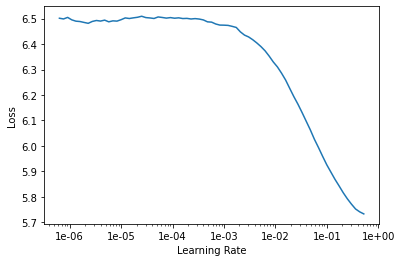

In [14]:
learn.recorder.plot(skip_end=15)


**Fine-tuning**

In [15]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.376977,3.892527,0.262581,32:01


In [16]:
learn.save('fit_head')
learn.load('fit_head');

#To complete the fine-tuning, we can then unfeeze and launch a new training.

learn.unfreeze()
learn.fit_one_cycle(10, 1e-3, moms=(0.8,0.7))


epoch,train_loss,valid_loss,accuracy,time
0,3.834572,3.747075,0.281521,44:35
1,3.706385,3.641047,0.295996,44:42
2,3.567002,3.572224,0.301813,44:43
3,3.325977,3.542834,0.307495,44:53
4,3.063303,3.575795,0.306385,44:58
5,2.765609,3.640568,0.303193,44:34
6,2.493811,3.723474,0.302327,44:47
7,2.272920,3.801863,0.300893,44:36
8,2.128902,3.841289,0.298999,44:29
9,2.059675,3.862184,0.298052,44:32


In [17]:
learn.save('fine_tuned')
learn.load('fine_tuned');


Let us test the model we have so far to see how well it works by giving it a few words.

In [18]:
TEXT = "I liked this airline because"
N_WORDS = 40
N_SENTENCES = 2

In [19]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

I liked this airline because you did n't care about my friends . They were PR and now i m in PHL . xxbos @americanair Please stop Cancelled Flightled my flight . You 're mad . xxbos @usairways
I liked this airline because of your merger . It is a joke to be in the business of the industry . xxbos @united Crazy to rebook ! The Internet is nothing but your people are so disgusted and the people


We have to save not only the model, but also its encoder, the part that's responsible for creating and updating the hidden state. For the next part, we don't care about the part that tries to guess the next word.

In [20]:
learn.save_encoder('fine_tuned_enc')


**Transfer Learning Classifier Model**

In [21]:
data_clas=TextClasDataBunch.from_csv(path, 'Tweets.csv',vocab=data_lm.vocab)


In [22]:
data_clas.save('data_clas.pkl')


In [23]:
data_clas = load_data(path, 'data_clas.pkl', bs=bs)


In [24]:
data_clas.show_batch()


text,target
xxbos @united i xxup just xxup asked xxup my xxup boyfriend xxup to xxup xxunk xxup over xxup the xxup xxunk xxup on xxup flight xxunk xxup he xxup said xxup yes xxrep 4 ! xxup best xxup day xxup ever ! ! ! xxup thank u xxup so xxup much xxrep 6 !,positive
xxbos @united xxup where xxup is xxup my xxup fucking xxup bag ? ! ? ! xxmaj where the fuck is my fucking bag ? ? ? xxup tell xxup me xxup now xxup or xxup give xxup me a xxup number xxup to xxup call a xxup human . xxup xxunk m,negative
"xxbos @united xxmaj hi , i m flying xxup sfo - xxup lax - xxup xxunk - xxup xxunk . xxmaj my connecting time in xxup lax is xxunk m . xxmaj is it enough time ? xxmaj do i have to collect my bag and xxunk on xxup xxunk ?",neutral
xxbos @virginamerica xxmaj many xxmaj thanks for the xxmaj follow . \n # xxunk # xxunk # xxup usa # xxmaj xxunk \n xxmaj looking for xxmaj any xxmaj help 😍 \n 💗 🇬 🇧 💗 🇺 🇸 💗 \n 🎀 xxunk 🎀 http : / / t.co / xxunk,neutral
xxbos @united xxup fail xxmaj you xxmaj cancelled xxmaj flightled our flight frm xxup xxunk and then used our reserv home to xxup iah ( from xxup sea ) for reflight xxmaj booking xxmaj problems w / out xxup our xxup xxunk ! ! # xxup xxunk,negative


We can then create a model to classify those reviews and load the encoder we saved before.

In [25]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)


In [26]:
learn

RNNLearner(data=TextClasDataBunch;

Train: LabelList (11711 items)
x: TextList
xxbos @southwestair xxmaj mad love http : / / t.co / 4ojrsdwpkk xxup nyc-,xxbos @americanair i xxmaj cancelled xxmaj flighted my flight . i really do n’t need this much trouble .,xxbos @americanair was n't able to get on hold . xxmaj your system kept kicking me to the main menu .,xxbos @jetblue xxmaj hey guys do you have a tail number assigned yet to flight xxunk for tomorrow ?,xxbos @southwestair no flights to xxup hrl :( is this a limited route ?
y: CategoryList
positive,negative,negative,neutral,negative
Path: /content;

Valid: LabelList (2929 items)
x: TextList
xxbos @united why do you guys split up the charges to credit cards ? xxmaj making it xxunk more expensive for people to fly with you guys on pts,xxbos @americanair i hear # xxmaj delta is offering xxunk miles to frequent flyers if their bags does n't come out within 20 minutes of landing thoughts ?,xxbos @united employee = xxunk . xxmaj do n't thr

In [27]:
# Transfer learned encoder from previous language model
learn.load_encoder('fine_tuned_enc')


RNNLearner(data=TextClasDataBunch;

Train: LabelList (11711 items)
x: TextList
xxbos @southwestair xxmaj mad love http : / / t.co / 4ojrsdwpkk xxup nyc-,xxbos @americanair i xxmaj cancelled xxmaj flighted my flight . i really do n’t need this much trouble .,xxbos @americanair was n't able to get on hold . xxmaj your system kept kicking me to the main menu .,xxbos @jetblue xxmaj hey guys do you have a tail number assigned yet to flight xxunk for tomorrow ?,xxbos @southwestair no flights to xxup hrl :( is this a limited route ?
y: CategoryList
positive,negative,negative,neutral,negative
Path: /content;

Valid: LabelList (2929 items)
x: TextList
xxbos @united why do you guys split up the charges to credit cards ? xxmaj making it xxunk more expensive for people to fly with you guys on pts,xxbos @americanair i hear # xxmaj delta is offering xxunk miles to frequent flyers if their bags does n't come out within 20 minutes of landing thoughts ?,xxbos @united employee = xxunk . xxmaj do n't thr

In [28]:
learn.lr_find()


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


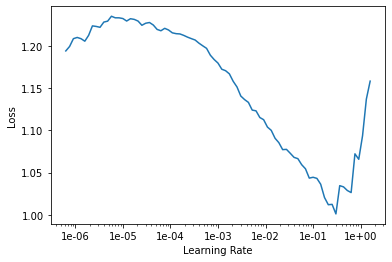

In [29]:
learn.recorder.plot()


In [30]:
learn.fit_one_cycle(1, 2e-2, moms=(0.8,0.7)) 


epoch,train_loss,valid_loss,accuracy,time
0,0.655744,0.526552,0.785251,18:19


In [31]:
learn.save('first')
learn.load('first')


RNNLearner(data=TextClasDataBunch;

Train: LabelList (11711 items)
x: TextList
xxbos @southwestair xxmaj mad love http : / / t.co / 4ojrsdwpkk xxup nyc-,xxbos @americanair i xxmaj cancelled xxmaj flighted my flight . i really do n’t need this much trouble .,xxbos @americanair was n't able to get on hold . xxmaj your system kept kicking me to the main menu .,xxbos @jetblue xxmaj hey guys do you have a tail number assigned yet to flight xxunk for tomorrow ?,xxbos @southwestair no flights to xxup hrl :( is this a limited route ?
y: CategoryList
positive,negative,negative,neutral,negative
Path: /content;

Valid: LabelList (2929 items)
x: TextList
xxbos @united why do you guys split up the charges to credit cards ? xxmaj making it xxunk more expensive for people to fly with you guys on pts,xxbos @americanair i hear # xxmaj delta is offering xxunk miles to frequent flyers if their bags does n't come out within 20 minutes of landing thoughts ?,xxbos @united employee = xxunk . xxmaj do n't thr

In [32]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.624297,0.485686,0.799249,18:24


In [33]:
learn.save('second')
learn.load('second');


In [34]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.569306,0.454098,0.816661,28:51


In [35]:
learn.save('third')
learn.load('third');


In [36]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.463011,0.447479,0.822465,47:16
1,0.453441,0.447210,0.824513,45:34


In [37]:
learn.save('Fourth')
learn.load('Fourth');


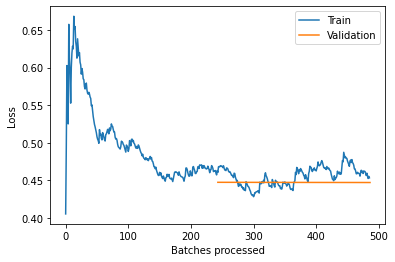

In [38]:
learn.recorder.plot_losses() 

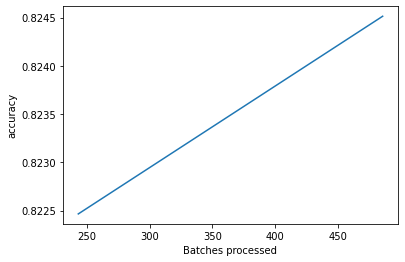

In [39]:
learn.recorder.plot_metrics()
